# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(df.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00000,108.00000,2019-03-07T00:00:00,3,2.70000,16.00000,51.00000,8,NaN,False,False,25.00000,NaN,Санкт-Петербург,18863.00000,16028.00000,1.00000,482.00000,2.00000,755.00000,NaN
1,7,3350000.00000,40.40000,2018-12-04T00:00:00,1,NaN,11.00000,18.60000,1,NaN,False,False,11.00000,2.00000,посёлок Шушары,12817.00000,18603.00000,0.00000,NaN,0.00000,NaN,81.00000
2,10,5196000.00000,56.00000,2015-08-20T00:00:00,2,NaN,5.00000,34.30000,4,NaN,False,False,8.30000,0.00000,Санкт-Петербург,21741.00000,13933.00000,1.00000,90.00000,2.00000,574.00000,558.00000
3,0,64900000.00000,159.00000,2015-07-24T00:00:00,3,NaN,14.00000,NaN,9,NaN,False,False,NaN,0.00000,Санкт-Петербург,28098.00000,6800.00000,2.00000,84.00000,3.00000,234.00000,424.00000
4,2,10000000.00000,100.00000,2018-06-19T00:00:00,2,3.03000,14.00000,32.00000,13,NaN,False,False,41.00000,NaN,Санкт-Петербург,31856.00000,8098.00000,2.00000,112.00000,1.00000,48.00000,121.00000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
initial_rows = df.shape[0] # Сохраняем начальное количество строк DataFrame

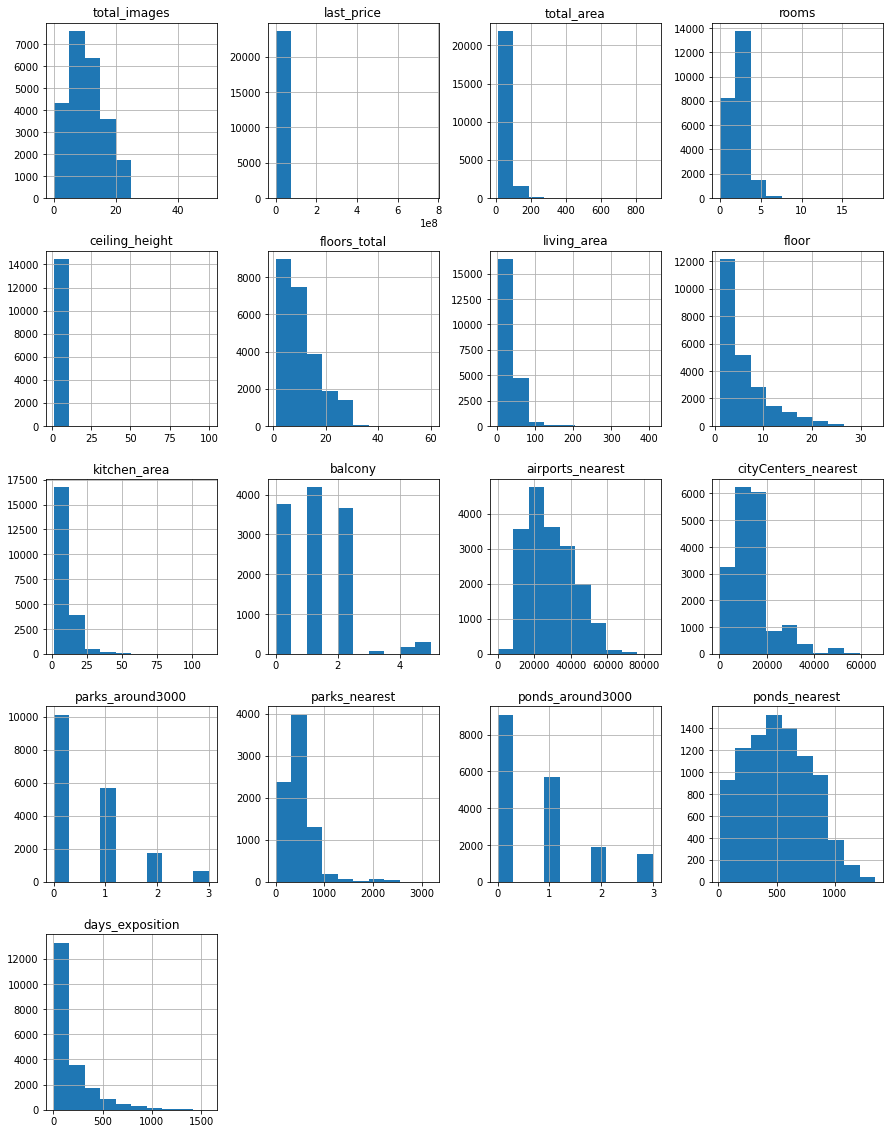

In [5]:
df.hist(figsize=(15, 20));

По итогу первого эта исследования, мы имеем примерно 24000 строк датасета, в которых сразу видим ошибки в типах некоторых данных, а также некоторые пропуски.

### Предобработка данных

**Найти и изучить пропущенные значения в столбцах:**

1. Определить, в каких столбцах есть пропуски.
2. Заполнить пропущенные значения там, где это возможно. Например, если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски можно заменить на число 0. Если логичную замену предложить невозможно, то оставить пропуски. Пропущенные значения — тоже важный сигнал, который нужно учитывать.
3. В ячейке с типом markdown указать причины, которые могли привести к пропускам в данных.

In [6]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


**Пропущенные значения в:**

1. Высота потолков (м). ceiling_height (38,8%)
2. Всего этажей в доме. floors_total (0,4%)
3. Жилая площадь в квадратных метрах (м²). living_area (8%)
4. Апартаменты (булев тип). is_apartment (88,3%)
5. Площадь кухни в квадратных метрах (м²). kitchen_area (9,6%)
6. Число балконов. balcony (48,6%)
7. Название населённого пункта. locality_name (0,2%)
8. Расстояние до ближайшего аэропорта в метрах (м). airports_nearest (23,4%)
9. Расстояние до центра города (м). cityCenters_nearest (23,3%)
10. Число парков в радиусе 3 км. parks_around3000 (23,3%)
11. Расстояние до ближайшего парка (м). parks_nearest (65,9%)
12. Число водоёмов в радиусе 3 км. ponds_around3000 (23,3%)
13. Расстояние до ближайшего водоёма (м). ponds_nearest (61,6%)
14. Сколько дней было размещено объявление (от публикации до снятия). days_exposition (13,4%)

In [8]:
df['balcony'] = df['balcony'].fillna(0)
# Удаляем строки, которые содержат пропущенные значения в столбце 'floors_total'
df.dropna(subset=['floors_total'], inplace=True)

**Возможные причины пропусков в данных:**

1. В недвижимости может не быть балконов. 
2. В пределах 3 км может не быть парков и водоёмов. Или возможно расстояние автоматически не подсчиталось до объектов. 
3. В недвижимости может не быть жилой площади и площади кухни. Это может относиться, к примеру к коммерческой недвижимости.
4. Расстояние до ближайшего аэропорта. Т.к. в населённом пункте может не быть аэропорта вовсе.
5. Расстояние до центра города. Т.к. населённый пункт может быть настолько мал, что нельзя понять, где в нём центр.
6. Владельцы недвижимости могли не предоставить эту информацию. 
7. Ошибки или проблемы в сборе или записи данных могли привести к пропускам информации. К ним могут относиться пропуски в:

- Высота потолков. Т.к. потолки есть в любом случае.
- Всего этажей в доме. Т.к. даже если в доме 1 этаж, это должно быть указано.
- Апартаменты (булев тип). Т.к. это либо апартаменты, либо нет.
- Название населённого пункта. Т.к. оно есть в любом случае.
- Сколько дней было размещено объявление. Т.к. если оно размещено, значит есть и срок, сколько висит объявление.

**Нужно рассмотреть типы данных в каждом столбце:**
    
1. Найти столбцы, в которых нужно изменить тип данных.
2. Преобразовать тип данных в выбранных столбцах.
3. В ячейке с типом markdown пояснить, почему нужно изменить тип данных.

**Меняем тип данных в 'first_day_exposition' на datetime**

In [9]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d %H:%M')

**Меняем вещественный тип данных в столбцах 'balcony' и 'floors_total' на целочисленный с помощью метода astype().**

In [10]:
df['balcony'] = df['balcony'].astype(int)
df['floors_total'] = df['floors_total'].astype(int)

Тип данных нужно было поменять, потому что:

1. Выражать количество балконов и количество этажей в виде вещественного типа данных некорректно. К примеру, не может быть 1,5 балкона или 2,5 этажа.
2. Если потребуется построить график, в котором будет использована дата и время, то это не получиться сделать, если эти значения будут иметь тип object

**Нужно изучить уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Можно заменить названия в существующем столбце или создать новый с названиями без дубликатов.**

In [11]:
df['locality_name'] = df['locality_name'].str.lower()
df['locality_name'] = (
    df['locality_name']
    .str.replace('ё', 'е')
    .replace(['городской поселок', 'коттеджный поселок', 'поселок городского типа', 'поселок при железнодорожной станции', 'поселок станции'], 'поселок', regex=True).replace(['садоводческое некоммерческое товарищество'], 'садовое товарищество', regex=True)
)

In [12]:
df['locality_name'].sort_values().unique()

array(['бокситогорск', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'высоцк', 'гатчина', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка',
       'деревня горбунки', 'деревня гостилицы', 'деревня заклинье',
       'деревня заневка', 'деревня зимитицы', 'деревня извара',
       'деревня иссад', 'деревня калитино', 'деревня кальтино',
       'деревня камышовка', 'деревня каськово', 'деревня келози',
       'деревня кипень', 'деревня кисельня', 'деревня колтуши',
       'деревня коркино', 'деревня котлы', 'деревня кривко',
       'деревня кудрово', 'деревня кузьмолово', 'деревня курковицы',
       'дер

In [13]:
df.duplicated().sum()

0

По итогу 2 этапа, были выявлены столбцы с пропущенными значениями, их количество и процент. Часть из них были заполнены, часть удалены. Остальное было пропущено. Так же были изменены типы данных в некоторых столбцах и обработаны неявные дубликаты. Явных дубликатов не было обнаружено.

### Посчитайте и добавьте в таблицу новые столбцы

**Добавьте в таблицу новые столбцы со следующими параметрами:**

1. цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой)

2. день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)

3. месяц публикации объявления

4. год публикации объявления

5. тип этажа квартиры (значения — «‎первый», «последний», «другой»)

6. расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений)

In [14]:
df['price_square_meter'] = round(df['last_price'] / df['total_area'], 2)
df['weekday_published'] = df['first_day_exposition'].dt.weekday
df['month_published'] = df['first_day_exposition'].dt.month
df['year_published'] = df['first_day_exposition'].dt.year
df['cityCenters_nearest_km'] = df['cityCenters_nearest'] // 1000

In [15]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
df['floor_type'] = df.apply(floor_type, axis=1)

### Проведите исследовательский анализ данных

Нужно изучить перечисленные ниже параметры объектов и построить отдельные гистограммы для каждого из этих параметров. В некоторых параметрах встречаются редкие и выбивающиеся значения. При построении гистограмм удалить их. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Нужно попробовать обработать аномалии в этом и других столбцах, если они есть. Если природа аномалии понятна и данные действительно искажены, то восстановить корректное значение. В противном случае удалить редкие и выбивающиеся значения.

Список параметров:

1. Общая площадь. 
2. Жилая площадь. 
3. Площадь кухни. 
4. Цена объекта. 
5. Количество комнат. 
6. Высота потолков. 
7. Тип этажа квартиры («первый», «последний», «другой»). 
8. Общее количество этажей в доме. 
9. Расстояние до центра города в метрах. 
10. Расстояние до ближайшего парка. 

Описать все наблюдения по параметрам в ячейке с типом markdown.

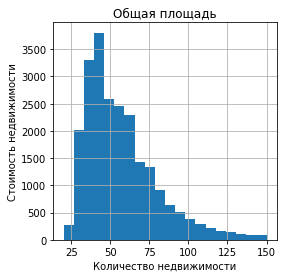

In [16]:
df['total_area'].hist(bins=20, range=(20,150), figsize=(4, 4));
plt.title('Общая площадь');
plt.xlabel('Количество недвижимости')
plt.ylabel('Стоимость недвижимости')
plt.show()

Большинство недвижимости имеет общую площадь до 100 м².

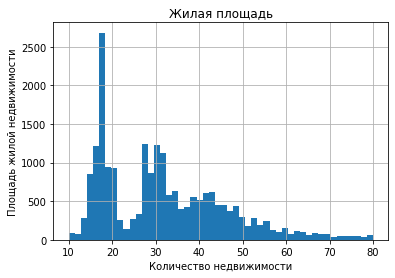

In [17]:
df['living_area'].hist(bins=50, range=(10,80), figsize=(6, 4));
plt.title('Жилая площадь');
plt.xlabel('Количество недвижимости')
plt.ylabel('Площадь жилой недвижимости')
plt.show()

Большинство недвижимости имеет жилую площадь до 50 м².

In [18]:
df['kitchen_area'].describe()

count   21382.00000
mean       10.56413
std         5.90432
min         1.30000
25%         7.00000
50%         9.10000
75%        12.00000
max       112.00000
Name: kitchen_area, dtype: float64

In [19]:
df['kitchen_area'].sort_values().unique()

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

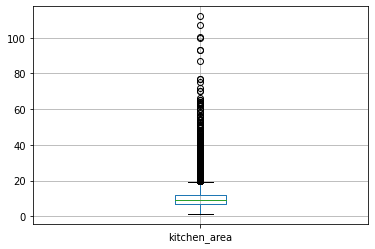

In [20]:
df.boxplot(['kitchen_area']);

In [21]:
# Удаление редких и выбивающихся значений
df = df[(df['kitchen_area'] >= 3) & (df['kitchen_area'] <= 20)]
# Замена аномальных значений
df.loc[df['kitchen_area'] > 20, 'kitchen_area'] = df.loc[df['kitchen_area'] > 20, 'kitchen_area'] / 10

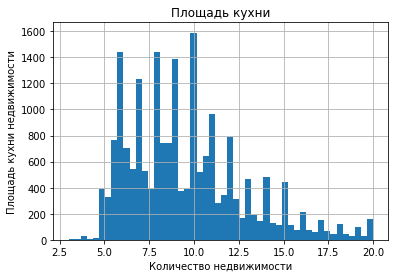

In [22]:
df['kitchen_area'].hist(bins=50, figsize=(6, 4));
plt.title('Площадь кухни');
plt.xlabel('Количество недвижимости')
plt.ylabel('Площадь кухни недвижимости')
plt.show()

Большинство недвижимости имеет площадь кухни 12 м².

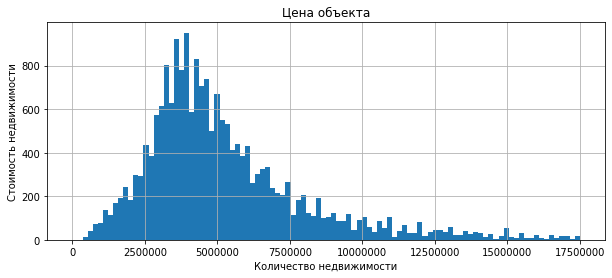

In [23]:
plt.title('Цена объекта');
plt.ticklabel_format(axis="y", style = 'plain', scilimits=(0,0))
plt.ticklabel_format(axis="x", style = 'plain', scilimits=(0,0))
df['last_price'].hist(bins=100, range=(0, 17500000), figsize=(10, 4));
plt.xlabel('Количество недвижимости')
plt.ylabel('Стоимость недвижимости')
plt.show()

Большинство недвижимости стоит в пределах 10 млн руб.

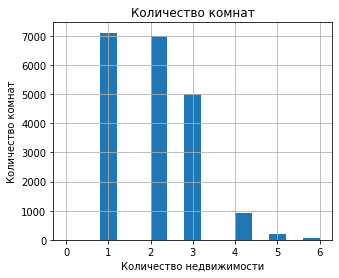

In [24]:
df['rooms'].hist(bins=15, range=(0,6), figsize=(5, 4));
plt.title('Количество комнат');
plt.xlabel('Количество недвижимости')
plt.ylabel('Количество комнат')
plt.show()

У большинства недвижимости от 1 до 3 комнат.

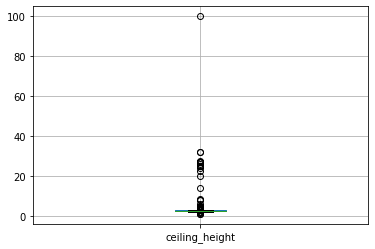

In [25]:
df.boxplot(['ceiling_height']);

In [26]:
# Замена аномальных значений
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] = df.loc[df['ceiling_height'] > 10, 'ceiling_height'] / 10

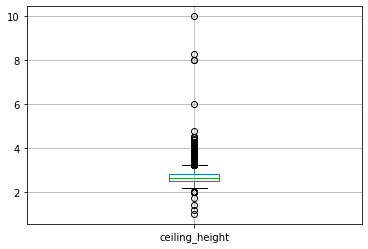

In [27]:
df.boxplot(['ceiling_height']);

In [28]:
#Код ревьюера
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20351 entries, 1 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            20351 non-null  int64         
 1   last_price              20351 non-null  float64       
 2   total_area              20351 non-null  float64       
 3   first_day_exposition    20351 non-null  datetime64[ns]
 4   rooms                   20351 non-null  int64         
 5   ceiling_height          12876 non-null  float64       
 6   floors_total            20351 non-null  int64         
 7   living_area             19960 non-null  float64       
 8   floor                   20351 non-null  int64         
 9   is_apartment            2462 non-null   object        
 10  studio                  20351 non-null  bool          
 11  open_plan               20351 non-null  bool          
 12  kitchen_area            20351 non-null  float6

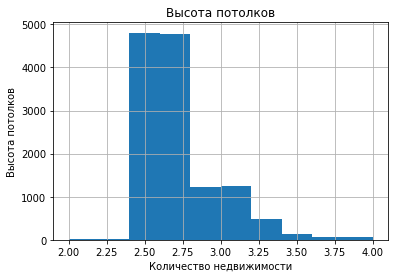

In [29]:
df['ceiling_height'].hist(range=(2, 4), figsize=(6, 4));
plt.title('Высота потолков');
plt.xlabel('Количество недвижимости')
plt.ylabel('Высота потолков')
plt.show()

In [30]:
print('Среднее', round(df['ceiling_height'].mean(), 1))
print('Медиана', round(df['ceiling_height'].median(), 1))

Среднее 2.7
Медиана 2.6


У большинства недвижимости, потолки в среднем 2,7 метров.

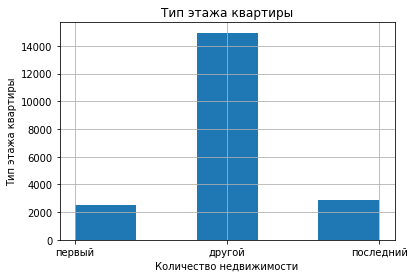

In [31]:
df['floor_type'].hist(bins=5, figsize=(6, 4));
plt.title('Тип этажа квартиры');
plt.xlabel('Количество недвижимости')
plt.ylabel('Тип этажа квартиры')
plt.show()

У большинства недвижимости не первый и не последний этаж.

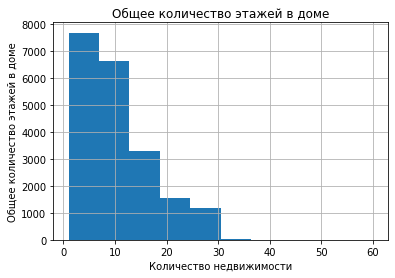

In [32]:
df['floors_total'].hist(figsize=(6, 4));
plt.title('Общее количество этажей в доме');
plt.xlabel('Количество недвижимости')
plt.ylabel('Общее количество этажей в доме')
plt.show()

В домах у большинства недвижимости 10 этажей.

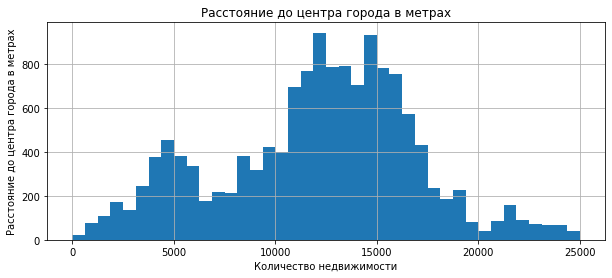

In [33]:
df['cityCenters_nearest'].hist(bins=40, range=(0,25000), figsize=(10, 4));
plt.title('Расстояние до центра города в метрах');
plt.xlabel('Количество недвижимости')
plt.ylabel('Расстояние до центра города в метрах')
plt.show()

У большинства недвижимости, расстояние до центра города 20000 м. или 20 км.

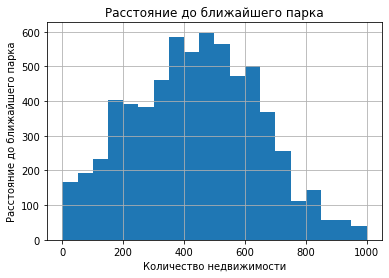

In [34]:
df['parks_nearest'].hist(bins=20, range=(0,1000), figsize=(6, 4));
plt.title('Расстояние до ближайшего парка');
plt.xlabel('Количество недвижимости')
plt.ylabel('Расстояние до ближайшего парка')
plt.show()

У большинства недвижимости, расстояние до ближайшего парка 500 м.

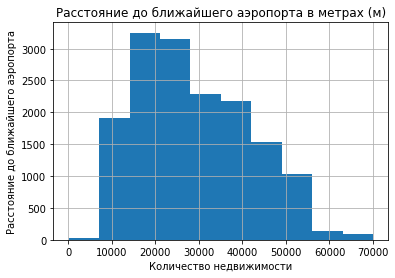

In [35]:
df['airports_nearest'].hist(range=(100,70000), figsize=(6, 4));
plt.title('Расстояние до ближайшего аэропорта в метрах (м)');
plt.xlabel('Количество недвижимости')
plt.ylabel('Расстояние до ближайшего аэропорта')
plt.show()

У большинства недвижимости, расстояние до ближайшего аэропорта 20000 м. или 20 км.

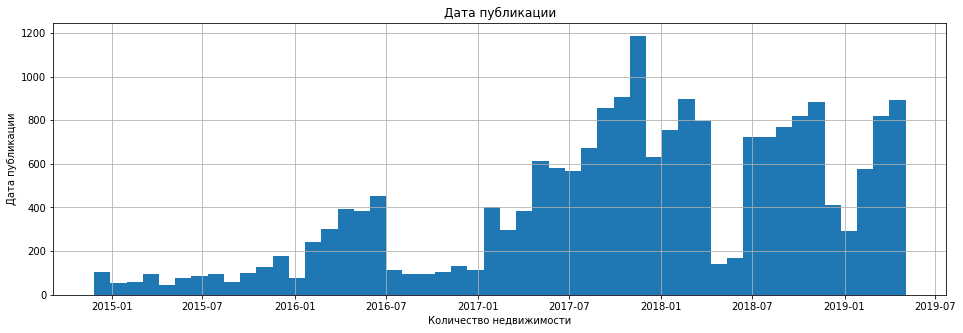

In [36]:
df['first_day_exposition'].hist(bins=50, figsize=(16, 5));
plt.title('Дата публикации');
plt.xlabel('Количество недвижимости')
plt.ylabel('Дата публикации')
plt.show()

Большинство объявлений были опубликованы в январе 2018 г.

In [37]:
# Рассчитываем долю оставшихся данных
remaining_percentage = (df.shape[0] / initial_rows) * 100

# Выводим информацию о доле оставшихся данных
print("Доля оставшихся данных после фильтрации: {:.2f}%".format(remaining_percentage))

Доля оставшихся данных после фильтрации: 85.87%


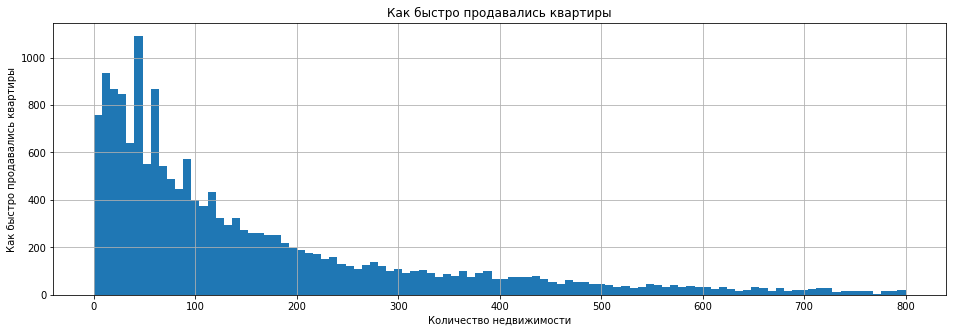

In [38]:
df['days_exposition'].hist(bins=100, range=(0,800), figsize=(16, 5));
plt.title('Как быстро продавались квартиры');
plt.xlabel('Количество недвижимости')
plt.ylabel('Как быстро продавались квартиры')
plt.show()

count   17618.00000
mean      182.46719
std       219.65740
min         1.00000
25%        44.00000
50%        99.00000
75%       234.00000
max      1580.00000
Name: days_exposition, dtype: float64

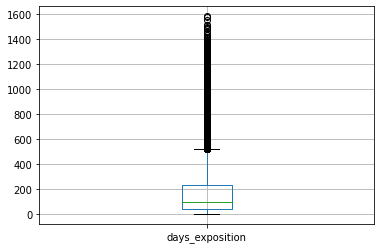

In [39]:
df.boxplot(['days_exposition']);
df['days_exposition'].describe()

В среднем квартира продаётся за полгода. Но если судить по медианному значению, то примерно за 3 месяца. Быстрыми продажи можно считать те, которые были завершены за 1.5 месяца, а долгими, которые были завершены за 4 с лишним года.

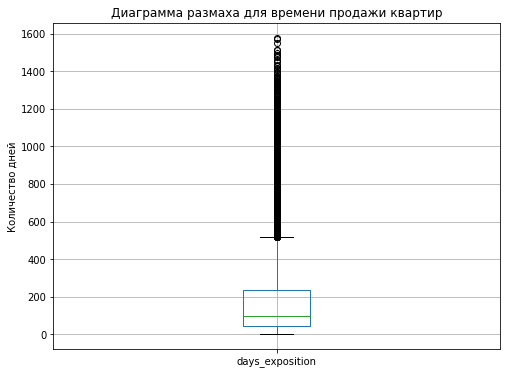

Границы для быстрых и долгих продаж:
До 44 дней считается быстрой продажей
После 234 дней считается долгой продажей

Количество быстрых продаж: 4447
Количество долгих продаж: 4407


In [40]:
# Определяем границы для быстрых и долгих продаж
quick_sale_boundary = df['days_exposition'].quantile(0.25)
long_sale_boundary = df['days_exposition'].quantile(0.75)

# График размаха
plt.figure(figsize=(8, 6))
df.boxplot(column=['days_exposition'])
plt.title('Диаграмма размаха для времени продажи квартир')
plt.ylabel('Количество дней')
plt.show()

# Оценка количества быстрых и долгих продаж
quick_sales = df[df['days_exposition'] <= quick_sale_boundary]
long_sales = df[df['days_exposition'] >= long_sale_boundary]

# Вывод результатов
print("Границы для быстрых и долгих продаж:")
print("До {:.0f} дней считается быстрой продажей".format(quick_sale_boundary))
print("После {:.0f} дней считается долгой продажей".format(long_sale_boundary))
print()
print("Количество быстрых продаж: {}".format(len(quick_sales)))
print("Количество долгих продаж: {}".format(len(long_sales)))

Какие факторы больше всего влияют на общую (полную) стоимость объекта? Нужно построить графики, которые покажут зависимость цены от указанных параметров. Для подготовки данных перед визуализацией можно использовать сводные таблицы.

In [41]:
round(df['total_area'].corr(df['last_price']),1)

0.7

Чем выше общая площадь, тем выше стоимость недвижимости

In [42]:
round(df['living_area'].corr(df['last_price']),1)

0.6

Чем выше жилая площадь, тем выше стоимость недвижимости

In [43]:
round(df['kitchen_area'].corr(df['last_price']),1)

0.4

Чем выше площадь кухни, тем выше стоимость недвижимости

In [44]:
round(df['rooms'].corr(df['last_price']),1)

0.4

Как правило, чем больше комнат, тем выше стоимость

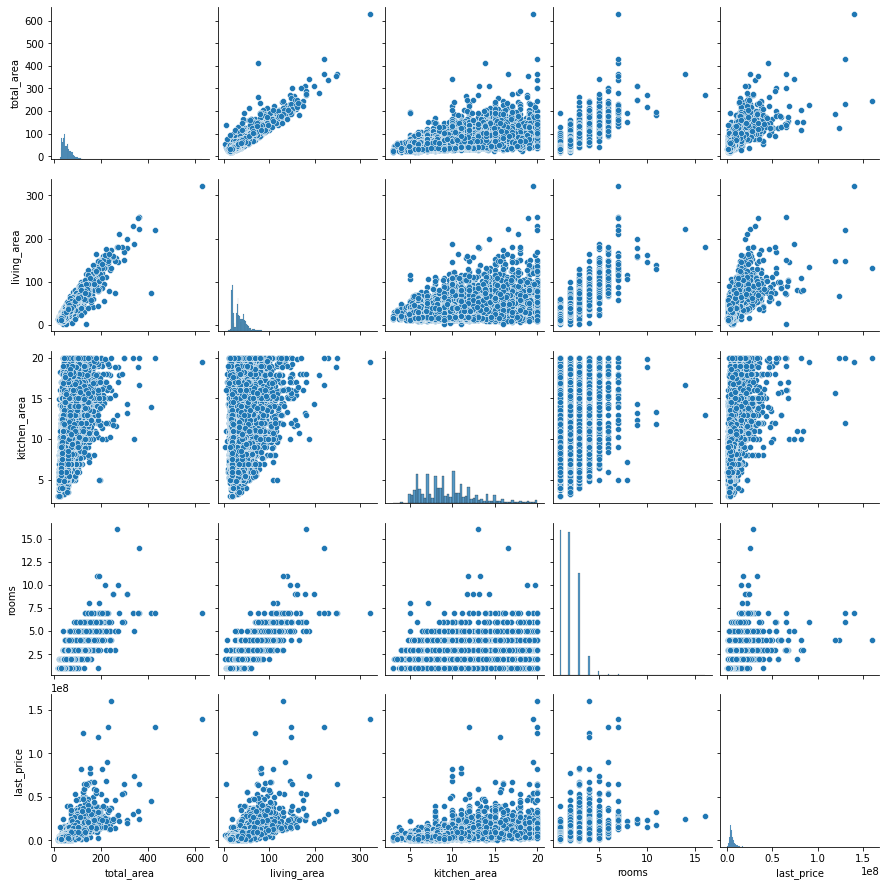

In [45]:
# Отбираем нужные параметры
parameters = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']

# Создаем сводную таблицу для удобства
selected_data = df[parameters]

# Строим графики зависимостей
sns.pairplot(selected_data)
plt.show()

In [46]:
round(df['floor'].corr(df['last_price']),1)

0.1

Этаж квартиры почти не влияет на цену

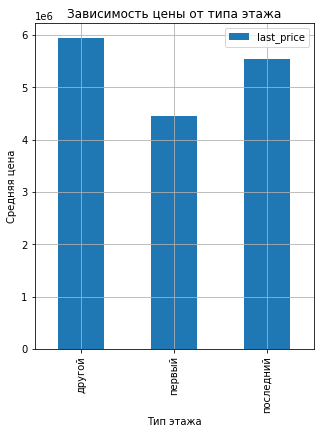

In [47]:
floor_type_price = df.pivot_table(index='floor_type', values='last_price', aggfunc='mean')
floor_type_price.plot.bar(grid=True, figsize=(5, 6))
plt.title('Зависимость цены от типа этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Средняя цена')
plt.show()

Самая низкая стоимость недвижимости, это та, которая находиться на 1 этаже

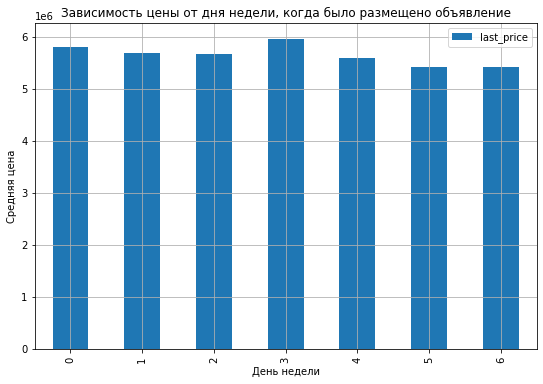

In [48]:
weekday_price = df.pivot_table(index='weekday_published', values='last_price', aggfunc='mean')
weekday_price.plot.bar(grid=True, figsize=(9, 6))
plt.title('Зависимость цены от дня недели, когда было размещено объявление')
plt.xlabel('День недели')
plt.ylabel('Средняя цена')
plt.show()

В основном цена не зависит от дня недели, в который было опубликовано объявление

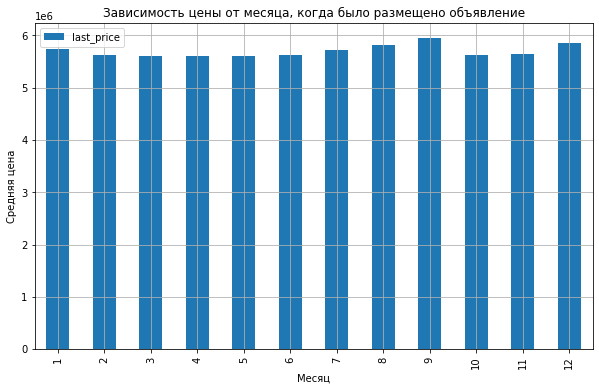

In [49]:
month_price = df.pivot_table(index='month_published', values='last_price', aggfunc='mean')
month_price.plot.bar(grid=True, figsize=(10, 6))
plt.title('Зависимость цены от месяца, когда было размещено объявление')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена')
plt.show()

В основном цена не зависит от месяца публикации объявления

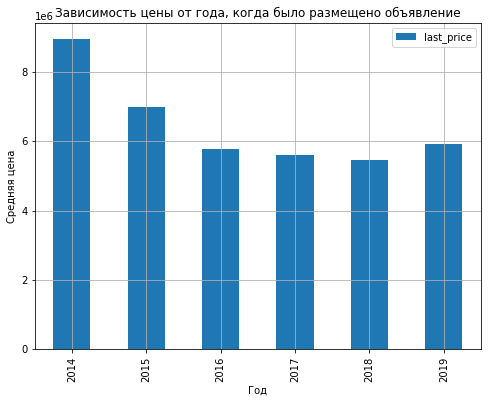

In [50]:
year_price = df.pivot_table(index='year_published', values='last_price', aggfunc='mean')
year_price.plot.bar(grid=True, figsize=(8, 6))
plt.title('Зависимость цены от года, когда было размещено объявление')
plt.xlabel('Год')
plt.ylabel('Средняя цена')
plt.show()

Можно наблюдать пиковые значения в 2014-2015 года, и небольшое снижение в период с 2016 по 2019

Нужно посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделить населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [51]:
df['locality_name'].value_counts().head(10)

санкт-петербург      13420
поселок мурино         445
поселок шушары         393
всеволожск             349
колпино                317
пушкин                 313
гатчина                290
поселок парголово      287
деревня кудрово        218
выборг                 193
Name: locality_name, dtype: int64

In [52]:
top_localities = df['locality_name'].value_counts().head(10).index

mean_price_per_sqm = df[df['locality_name'].isin(top_localities)].groupby('locality_name')['price_square_meter'].mean()

sorted_mean_price_per_sqm = mean_price_per_sqm.sort_values()

lowest_price_locality = sorted_mean_price_per_sqm.index[0]
highest_price_locality = sorted_mean_price_per_sqm.index[-1]

print("Населенный пункт с самой низкой стоимостью квадратного метра:", lowest_price_locality)
print("Населенный пункт с самой высокой стоимостью квадратного метра:", highest_price_locality)
print()
print(sorted_mean_price_per_sqm)

Населенный пункт с самой низкой стоимостью квадратного метра: выборг
Населенный пункт с самой высокой стоимостью квадратного метра: санкт-петербург

locality_name
выборг               58122.31534
гатчина              68496.42007
всеволожск           68827.31275
колпино              75145.34568
поселок шушары       78415.72392
поселок мурино       85220.01151
поселок парголово    90653.96014
деревня кудрово      92772.78922
пушкин              101578.43495
санкт-петербург     110415.95157
Name: price_square_meter, dtype: float64


Ранее я посчитал расстояние до центра в километрах. Теперь нужно выделить квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислить среднюю цену каждого километра. Описать, как стоимость объектов зависит от расстояния до центра города.

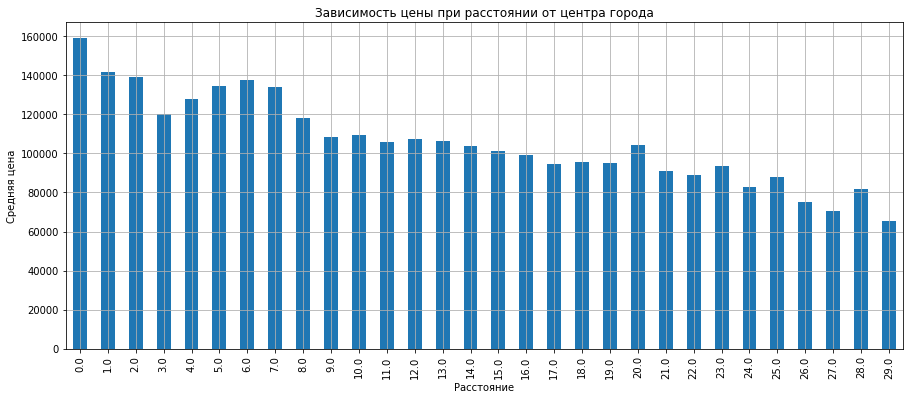

In [53]:
centres_piter = df[df['locality_name'].isin(['санкт-петербург'])].groupby('cityCenters_nearest_km')['price_square_meter'].mean()
centres_piter.plot.bar(grid=True, figsize=(15, 6))
plt.title('Зависимость цены при расстоянии от центра города')
plt.xlabel('Расстояние')
plt.ylabel('Средняя цена')
plt.show()

Как правило, чем дальше расстояние от центра, тем ниже стоимость недвижимости

### Общий вывод

На начальном этапе, я работал с данными, которые составляли около 24000 строк.

В части данных были пропуски. Частично они были заполнены, частично удалены. Остальные пропуски были оставлены. В некоторых столбцах были изменены неподходящие типы данных.

В столбце с населёнными пунктами, были устранены неявные дубликаты.

Были добавлены столбцы с ценой одного квадратного метра, днём недели публикации объявления, типом этажа квартиры, и расстоянием до центра города в километрах.

Был проведён исследовательский анализ данных, в ходе которого были выявлены следующие зависимости:

1.	Большинство недвижимости имеет общую площадь до 100 м².
2.	Большинство недвижимости имеет жилую площадь до 50 м².
3.	Большинство недвижимости имеет площадь кухни 12 м².
4.	Большинство недвижимости стоит в пределах 10 млн руб.
5.	У большинства недвижимости от 1 до 3 комнат.
6.	У большинства недвижимости, потолки в среднем 2,7 метров.
7.	У большинства недвижимости не первый и не последний этаж.
8.	В домах у большинства недвижимости 10 этажей.
9.	У большинства недвижимости, расстояние до центра города 20000 м. или 20 км.
10.	У большинства недвижимости, расстояние до ближайшего парка 500 м.
11.	У большинства недвижимости, расстояние до ближайшего аэропорта 20000 м. или 20 км.
12.	Большинство объявлений были опубликованы в январе 2018 г.
13.	Чем выше общая площадь, тем выше стоимость недвижимости.
14.	Чем выше жилая площадь, тем выше стоимость недвижимости.
15.	Чем выше площадь кухни, тем выше стоимость недвижимости.
16.	Как правило, чем больше комнат, тем выше стоимость.
17.	Этаж квартиры почти не влияет на цену.
18.	Самая низкая стоимость недвижимости, это та, которая находиться на 1 этаже.
19.	В основном цена не зависит от дня недели, в который было опубликовано объявление.
20.	В основном цена не зависит от месяца публикации объявления.
21.	В 2014-2015 годах была пиковая стоимость жилья, и небольшое снижение в период с 2016 по 2019.
22.	Населенный пункт с самой низкой стоимостью квадратного метра: Всеволожск.
23.	Населенный пункт с самой высокой стоимостью квадратного метра: Санкт-Петербург
24.	Как правило, чем дальше расстояние от центра, тем ниже стоимость недвижимости.

Так же было выяснено, что в среднем квартира продаётся за полгода. Но если судить по медианному значению, то примерно за 3 месяца. Быстрыми продажи можно считать те, которые были завершены за 1.5 месяца, а долгими, которые были завершены за 4 с лишним года.

Рекомендуется при сборе данных не допускать пропусков, аномальных значений, и значений, которые представлены в некорректной форме.

В следствии проделанного исследования, можно построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.